# ADO.NET

ADO.NET est un mini-framework utilisé en .NET pour interagir avec des bases de données relationnelles.

- Ce framework suit un modèle très spécifique d’interfaces et de méthodes afin de rendre l’interaction uniforme entre les différents types de base de données

ADO.NET ne peut pas être utilisé seul pour interagir avec une base de données; un data provider (fournisseur de données) est requis:

- Un data provider est habituellement défini pour les bases de données les plus connues telles que SQL Server, Oracle, MySQL, SQLite, etc.

- Chaque data provider doit implémenter les interfaces et méthodes de ADO.NET de manière personnalisée pour le type de base de données qu’il représente.


ADO.NET peut être utilisé de trois manières différentes :
1. **En mode connecté**
  - Le programmeur ouvre une connexion à la base de données
  - Le programmeur transfert/manipule les données
  - Le programmeur ferme la connexion à la base de données
  

2. **En mode déconnecté**
  - Le programmeur manipule les données sur le client (et non directement sur la base de données)
  - ADO.NET gère automatiquement la connexion et l’interaction avec la base de données
  

3. **Avec le « Entity Framework »**
  - Le programmeur utilise le LINQ pour manipuler les données
  - ADO.NET/Entity Framework s’occupe de l’interaction avec la base de données pour chaque exécution LINQ


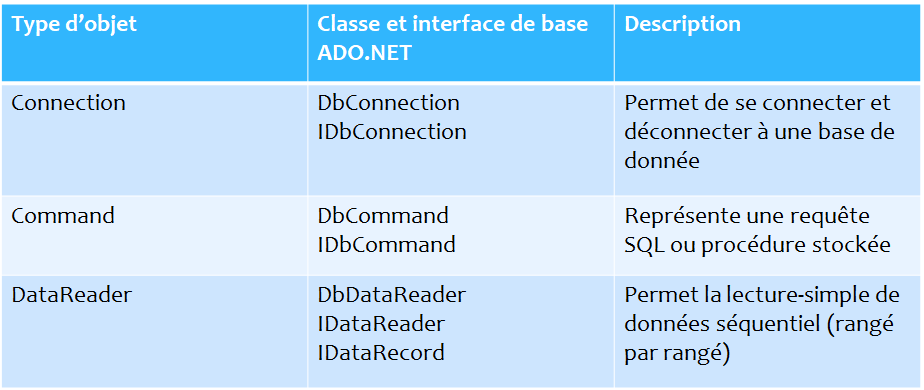

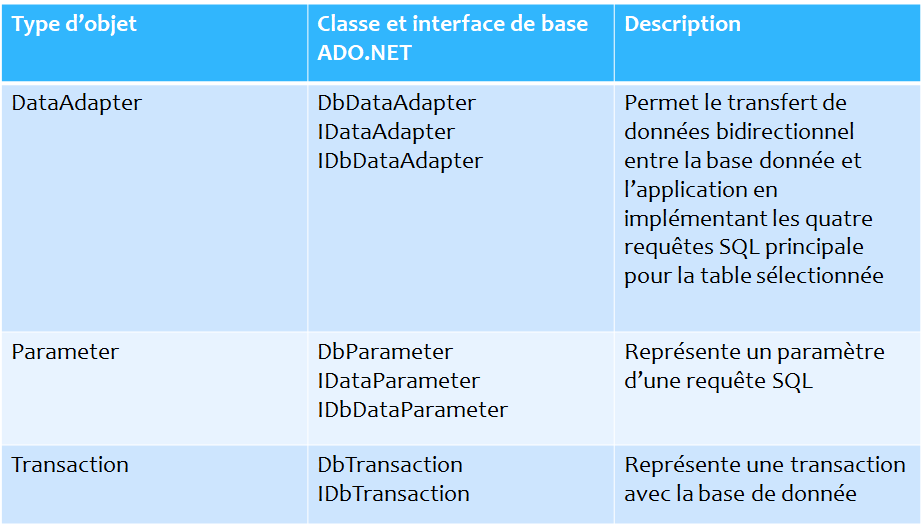

## ADO.NET en mode connecté

Lorsque ADO.NET est utilisé en mode connecté, toutes les interactions avec les données sont faites à la base de données directement en gardant une connexion physique ouverte.

Le terme de « mode connecté » signifie que les modifications de données sont faites au niveau de la base de données et non simplement en mémoire.

### `IDbConnection`

L’interface `IDbConnection` représente toutes les méthodes qu’un Data Provider doit implémenter pour établir et gérer une connexion avec une base de données

À noter que `IDbConnection` implémente `IDisposable`
- Il est TRÈS fortement suggéré d’utiliser le mot clé « `using` » avec tout objet « connexion » en ADO.NET

Les membres les plus utilisés sont :
- `ConnectionString` : représente l’information requise pour établir une connexion avec la base de données
- `BeginTransaction()` : crée et retourne un objet « transaction » pour la connexion courante
- `Close()` : ferme la connexion à la base de données
- `CreateCommand()` : crée un objet « commande » pour la connexion courante
- `Open()` : ouvre la connexion à la base de données

Ressource: https://docs.microsoft.com/en-us/dotnet/standard/data/sqlite/?tabs=netcore-cli

**Example :** Prenons par exemple une connexion à une base de données SQLite. Une nouvelle instance de SqliteConnection (implémente IDbconnection) est nécessaire.

Installation du NuGet package `Microsoft.Data.SQLite`

In [1]:
#r "nuget: Microsoft.Data.SQLite, 5.0.4"

The below script needs to be able to find the current output cell; this is an easy method to get it.

Installed package Microsoft.Data.SQLite version 5.0.4

Ajouter les `using` pour les namespaces

In [3]:
using System.Data;
using Microsoft.Data.Sqlite;

Ouverture et fermeture de la connexion à l'aide d'un `try/finnaly`.

In [4]:
var connectionString = "Data Source=hello.db";

IDbConnection connection;

try
{
    connection = new SqliteConnection(connectionString);
    
    // Ouvre la connection
    connection.Open();
    
    Console.WriteLine(connection.State.ToString());
}
finally
{
    // // La méthode Dispose() appelle la méthode Close()
    //connection?.Close();
    
    connection?.Dispose();
}

Console.WriteLine(connection?.State.ToString());

Open
Closed


Ouverture et fermeture de la connexion à l'aide d'un `using`.

In [5]:
var connectionString = "Data Source=hello.db";

using (var connection = new SqliteConnection(connectionString))
{
    // Ouvre la connection
    connection.Open();
    
    // Affice le status
    Console.WriteLine(connection.State.ToString());
}

Open


### `IDbTransaction`

L’interface `IDbTransaction` représente toutes les méthodes qu’un Data Provider doit implémenter pour gérer une transaction avec une base de données.

À noter que `IDbTransaction` implémente `IDisposable`.

Les membres les plus utilisés sont :
- `Commit()` : applique les modifications de l’état de la base de données
- `Rollback()` : retourne l’état de la base de données comme elle était avant la création de la transaction

In [14]:
var connectionString = "Data Source=hello.db";

using (var connection = new SqliteConnection(connectionString))
{
    // Ouvre la connection
    connection.Open();

    using (var transaction = connection.BeginTransaction())
    {
        try
        {
            // Éxécute du code SQL
            // ...
        
            // Tout a bien fonctionné, on sauvegarde les modifications
            transaction.Commit();
        }
        catch (Exception ex)
        {
            Console.WriteLine(ex.Message);
        
            // Cancel la transaction
            transaction.Rollback();
        }
    }
}

### `IDbCommand`

L’interface `IDbCommand` représente toutes les méthodes qu’un Data Provider doit implémenter pour créer et exécuter une requête SQL.

À noter que `IDbCommand` implémente `IDisposable`.

Les membres les plus utilisés sont :
- `CommandText` : la requête SQL ou nom de la procédure stockée
- `CommandType` : le type de commande; requête SQL ou procédure stockée
- `Parameters` : la liste des objets « paramètre »
- `Transaction` : l’objet « transaction » à utiliser pour la commande

- `CreateParameter()` : crée et retourne un objet « paramètre » pour cette commande
- `ExecuteNonQuery()` : exécute une requête SQL ne retournant aucune donnée
  - (INSERT, UPDATE, DELETE, etc.)
- `ExecuteReader()` : exécute une requête SQL retournant des données et retourne un objet « data reader » qui va être utilisé pour lire ces données
- `ExecuteScalar()` : exécute une requête SQL retournant des données et retourne la valeur de la première colonne de la première rangée
  - Souvent utilisé pour un INSERT avec une clé primaire qui s'auto-incrémente

On ajoute maintenant un nouvel objet « commande » à l’intérieur du bloc « `try/catch` » en spécifiant l’objet « transaction ».

In [24]:
var connectionString = "Data Source=hello.db";

using (var connection = new SqliteConnection(connectionString))
{
    // Ouvre la connection
    connection.Open();

    using (var transaction = connection.BeginTransaction())
    {
        try
        {
            // Éxécute du code SQL
            // Création d'une nouvelle commande
            using (var command = connection.CreateCommand())
            {
                command.Transaction = transaction;
                
                command.CommandText = @"
                    INSERT INTO User (Name, Age)
                    VALUES ('Zoé', 5)";
                    
                int rowsAffected = command.ExecuteNonQuery();
                
                command.CommandText = "SELECT LAST_INSERT_ROWID()";
                long id = (long)command.ExecuteScalar();                
                Console.WriteLine(id);
            }
        
            // Tout a bien fonctionné, on sauvegarde les modifications
            transaction.Commit();
        }
        catch (Exception ex)
        {
            Console.WriteLine(ex.Message);
        
            // Cancel la transaction
            transaction.Rollback();
        }
    }
}

13


### `IDbDataParameter` (et `IDataParameter`)

L’interface `IDbDataParameter` représente toutes les méthodes qu’un Data Provider doit implémenter pour ajouter des paramètres à une requête SQL.

Les membres les plus utilisés sont :
- `DbType` : le type d’objet (selon ADO.NET) que représente le paramètre
- `Direction` : défini si le paramètre est de est utilisé pour passer une valeur à la base de données ou le contraire (IN vs OUT)
- `ParameterName` : le nom du paramètre dans la requête SQL
- `Value` : la valeur du paramètre

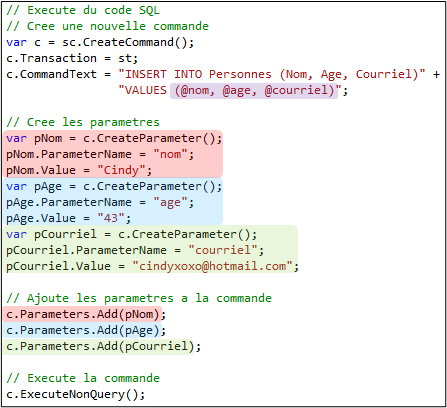

In [25]:
var connectionString = "Data Source=hello.db";

string nom = "Yvon";
int age = 67;

using (var connection = new SqliteConnection(connectionString))
{
    // Ouvre la connection
    connection.Open();

    using (var transaction = connection.BeginTransaction())
    {
        try
        {
            // Éxécute du code SQL
            // Création d'une nouvelle commande
            using (var command = connection.CreateCommand())
            {
                command.Transaction = transaction;
                
                command.CommandText =
                @"
                    INSERT INTO user (name, age)
                    VALUES ($name, $age)
                ";
                command.Parameters.AddWithValue("$name", nom);
                command.Parameters.AddWithValue("$age", age);
                    
                command.ExecuteNonQuery();
            }
        
            // Tout a bien fonctionné, on sauvegarde les modifications
            transaction.Commit();
        }
        catch (Exception ex)
        {
            Console.WriteLine(ex.Message);
        
            // Cancel la transaction
            transaction.Rollback();
        }
    }
}

### `IDataReader` (et `IDataRecord`)

L’interface `IDataReader` représente toutes les méthodes qu’un Data Provider doit implémenter pour lire des données séquentiellement.

 - Un objet « data reader » est la manière recommandée de lire des données (dans une table avec beaucoup de rangées, la méthode DataAdapter.Fill va être très lente).

À noter que `IDataReader` implémente `IDisposable`.

Les membres les plus utilisés sont :
- `FieldCount` : indique le montant de colonne retournée
- `this[name]` : retourne la valeur de la colonne spécifiée par nom
- `this[i]` : retourne la valeur de la colonne spécifiée par index
- `NextResult()` : passe à la prochaine commande
- `Read()` : passe à la prochaine rangée

In [39]:
using (var connection = new SqliteConnection("Data Source=hello.db"))
{
    connection.Open();

    using (var command = connection.CreateCommand())
    {
        command.CommandText =
        @"
            SELECT name, age
            FROM user
        ";

        // Éxécute la commande avec un data reader
        using (var reader = command.ExecuteReader())
        {
            // Éxécute chanque rangée
            while (reader.Read())
            {
                var nom = reader.GetString(0);               
                var age = reader.GetInt64(1);
                
                //var name = reader.GetString("Name");
                //Console.WriteLine(name);

                Console.WriteLine($"Bonjour, {nom} vous avez {age} ans!");
            }
        }   
    }
}

Bonjour, Alice vous avez 12 ans!
Bonjour, Benoit vous avez 25 ans!
Bonjour, Christine vous avez 11 ans!
Bonjour, Deric vous avez 36 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, XXX vous avez 10 ans!
Bonjour, Zoé vous avez 5 ans!
Bonjour, Yvon vous avez 67 ans!


## Configuration de la « Connection String »

La façon recommandée de stocker la « Connection String » est dans un fichier de configuration à l’extérieur du code.

- Stocker la « Connection String » à l’intérieur du code rend la maintenance plus complexe; si un mot de passe ou nom de serveur d’une base de données change, le code doit être recompilé afin de réparer ce problème
- Stocker la « Connection String » à l’extérieur du code fait en sorte qu’elle peut être modifiée sans recompiler l’application


En **.NET Framework**, utilisation d'un fichier XML `*.exe.config` ou `web.config`.

La section pour les « Connection String » est :

``` xml
<?xml version="1.0" encoding="utf-8"?>
<configuration>
  <connectionStrings>
    <add name="localhost"
         connectionString="Server=(localdb)\mssqllocaldb;Database=Blogging;Trusted_Connection=True;" />
  </connectionStrings>
</configuration>
```

Pour lire les « Connection String » stockées à l’intérieur du fichier de configuration, le assembly « `System.Configuration` » doit premièrement être ajouté à la liste de référence.

La section des « Connection String » peut être lue à l’aide de l’indexeur `ConfigurationManager.ConnectionStrings[name]`. Cette classe statique est retrouvée à l’intérieur de l’espace de nom « `System.Configuration` ».

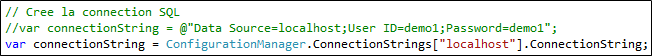

En **.NET Core / .NET 5.0**, utilisation d'un fichier JSON `appsettings.json`.

``` json
{
  "Logging": {
    "LogLevel": {
      "Default": "Warning"
    }
  },

  "ConnectionStrings": {
    "BloggingDatabase": "Server=(localdb)\\mssqllocaldb;Database=EFGetStarted.ConsoleApp.NewDb;Trusted_Connection=True;"
  },
}
```

Pour lire les « Connection String » stockées à l’intérieur du fichier de configuration, utilisation de l'interface `IConfiguration`.

``` csharp
static class Program
{
    public static readonly IConfiguration Configuration;

    static Program()
    {
        Configuration = new ConfigurationBuilder()
            .SetBasePath(Directory.GetCurrentDirectory())
            .AddJsonFile("appsettings.json", optional: false, reloadOnChange: true)
            .Build();
    }

    private static void Main(string[] args)
    {
        var connectionString = Configuration.ConnectionStrings["BloggingDatabase"];
    }
}
```